In [1]:
!pip install datasets wandb

In [2]:
# PyTorch
import torch
import torchvision
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
from torch import nn

import glob

# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor, Resize
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification, AutoFeatureExtractor, SwinForImageClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import requests
import os

In [4]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x, axis=1):
  return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

In [93]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)


processor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224")
model = SwinForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224", num_labels=3, ignore_mismatched_sizes=True)


inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

print("Prediction:", logits)

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction: tensor([[-0.2376, -0.1575, -0.0358]], grad_fn=<AddmmBackward0>)


In [5]:
import wandb

#b8274abb6012dc4cc15ce278754f4f6f0e2942e6

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
import cv2

class MotionBlurTransform(torch.nn.Module):
    def __init__(self, min_kernel_size = 15, max_kernel_size = 30):
        self.max_kernel_size = max_kernel_size
        self.min_kernel_size = min_kernel_size
        
    def __call__(self, img):
        img = np.array(img)
        # Do some transformations
        kernel_size_v = img.shape[0] // 15 #np.random.randint(self.min_kernel_size, self.max_kernel_size)
        kernel_size_h = img.shape[1] // 15 #np.random.randint(self.min_kernel_size, self.max_kernel_size)

        # Create the vertical kernel.
        kernel_v = np.zeros((kernel_size_v, kernel_size_v))

        # Create a copy of the same for creating the horizontal kernel.
        kernel_h = np.zeros((kernel_size_h, kernel_size_h))

        # Fill the middle row with ones.
        kernel_v[:, int((kernel_size_v - 1)/2)] = np.ones(kernel_size_v)
        kernel_h[int((kernel_size_h - 1)/2), :] = np.ones(kernel_size_h)

        # Normalize.
        kernel_v /= kernel_size_v
        kernel_h /= kernel_size_h

        if np.random.rand() < 0.5:
          # Apply the vertical kernel.
          mb = cv2.filter2D(img, -1, kernel_v)
        else:
          # Apply the horizontal kernel.
          mb = cv2.filter2D(img, -1, kernel_h)

        return Image.fromarray(np.uint8(mb))

In [116]:
from sklearn.model_selection import train_test_split

class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.

    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: torch.Tensor = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.

        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss

class AnimalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_foc = FocalLoss(alpha=torch.tensor([4.763, 3.155, 2.113]).cuda())
        loss = loss_foc(logits.squeeze(), labels.squeeze())
        return (loss, outputs) if return_outputs else loss

class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, image_paths, empty_image_paths, p=0.3):
        self.df = pd.read_csv(csv_path)
        self.csv_path = csv_path
        self.image_paths = image_paths
        self.empty_image_paths = empty_image_paths

        empty_images = [image.split("/")[-1] for image in glob.glob("/kaggle/input/digbreak/images_empty/*")]
        df = pd.DataFrame(empty_images, columns=["Name"])
        df["Class"] = 2
        df["Bbox"] = None

        self.df = pd.concat([self.df ,df], axis=0).reset_index().drop(["index"], axis=1)
        
        self.p = p
        self.to_tensor_fn = ToTensor()
        self.do_transform = True

        self.transforms = v2.Compose([
            v2.Resize((224, 224)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomRotation(degrees=(0, 180)),
        ])

        self.emp_img_transforms = v2.Compose([
            v2.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(0.35, 1.3333333333333333)), # Random resized crop for prevent meaningless images
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomRotation(degrees=(0, 180)),
        ])

        self.pos_to_neg_transforms = v2.Compose([
            ToPILImage(), 
            MotionBlurTransform(20,40),
            ToTensor(),
        ])

        self.default_transforms = v2.Compose([
            v2.Resize((224, 224))
        ])

    def __getitem__(self, idx):
        el = self.df.iloc[idx]
        cls = el.Class

        image = self.load_image(el.Name, cls)
        
        if cls == 0 or cls == 1: 
            coords = [float(num) for num in el.Bbox.split(",")]
            t_shape = image.shape
            x_c, y_c = int(t_shape[2] * coords[0]), int(t_shape[1] * coords[1])
            w, h = int(t_shape[2] * coords[2]) // 2, int(t_shape[1] * coords[3]) // 2
    
            image = image[:, y_c - h: y_c + h, x_c - w: x_c+w]

            image = self.transforms(image)
                
        elif cls == 2:
            image = self.emp_img_transforms(image)
        else:
            raise Exception("Not supported class")

        item = {}
        item["pixels"] = image
        item['labels'] = torch.tensor(cls)
        return item

    def load_image(self, name, cls):
        if cls == 2:
            path = os.path.join(self.empty_image_paths, name)
        else:
            path = os.path.join(self.image_paths, name)
        return self.to_tensor_fn(Image.open(path))

    def __len__(self):
        return self.df.shape[0]

    
csv_path = "/kaggle/input/digbreak/annotation.csv"
image_path = "/kaggle/input/digbreak/images"
image_path_empty = "/kaggle/input/digbreak/images_empty"

dataset = AnimalDataset(csv_path, image_path, image_path_empty)
val_size = 400
#train_dataset, val_dataset = torch.utils.data.random_split(dataset, [3768 - val_size, val_size])
TEST_SIZE = 0.13
SEED = 42
train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=TEST_SIZE,
    random_state=SEED
)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, test_indices)

tensor(0)


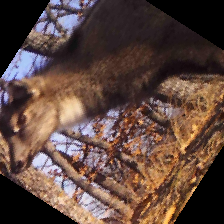

In [117]:
item = train_dataset[2153]
print(item["labels"])
ToPILImage()(item["pixels"])

In [15]:
counts = dataset.df.Class.value_counts()
s = sum(counts)
w_0 = counts.loc[0] / s
w_1 = counts.loc[1] / s
w_2 = counts.loc[2] / s
1/w_0, 1/w_1, 1/w_2

(4.763590391908976, 3.155778894472362, 2.1132922041503086)

In [94]:
train_args = TrainingArguments(
    output_dir="output-models",
    save_total_limit=2,
    report_to="wandb",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=10,
    num_train_epochs=40,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="logs",
    remove_unused_columns=False,
    logging_steps = 20,
)


def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = softmax(predictions)
    return dict(
        roc_auc=roc_auc_score(labels, predictions, multi_class='ovr')
        )

trainer = AnimalTrainer(
    model,
    train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [95]:
trainer.train()

TrainOutput(global_step=2296, training_loss=0.960569481401078, metrics={'train_runtime': 2857.0875, 'train_samples_per_second': 45.893, 'train_steps_per_second': 2.296, 'total_flos': 3.595476723272147e+18, 'train_loss': 0.960569481401078, 'epoch': 14.0})

In [354]:
model_dir = "/kaggle/working/"
trainer.save_model(model_dir + '/microsoft-swin-base-patch4-window7-224-3-cls-aug')

In [355]:
!zip -r microsoft-swin-base-patch4-window7-3-cls-aug.zip /kaggle/working/microsoft-swin-base-patch4-window7-224-3-cls-aug

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/microsoft-swin-base-patch4-window7-224-3-cls-aug/ (stored 0%)
  adding: kaggle/working/microsoft-swin-base-patch4-window7-224-3-cls-aug/model.safetensors (deflated 7%)
  adding: kaggle/working/microsoft-swin-base-patch4-window7-224-3-cls-aug/preprocessor_config.json (deflated 45%)
  adding: kaggle/working/microsoft-swin-base-patch4-window7-224-3-cls-aug/config.json (deflated 54%)
  adding: kaggle/working/microsoft-swin-base-patch4-window7-224-3-cls-aug/training_args.bin (deflated 52%)


In [96]:
y_pred = trainer.predict(val_dataset)

In [97]:
sm_y_pred = softmax(y_pred.predictions)

Label: 1 Pred: [0.015107 0.984709 0.000184]
Label: 2 Pred: [0.001096 0.003359 0.995546]
Label: 2 Pred: [0.000015 0.000006 0.999979]
Label: 0 Pred: [0.955523 0.043543 0.000934]


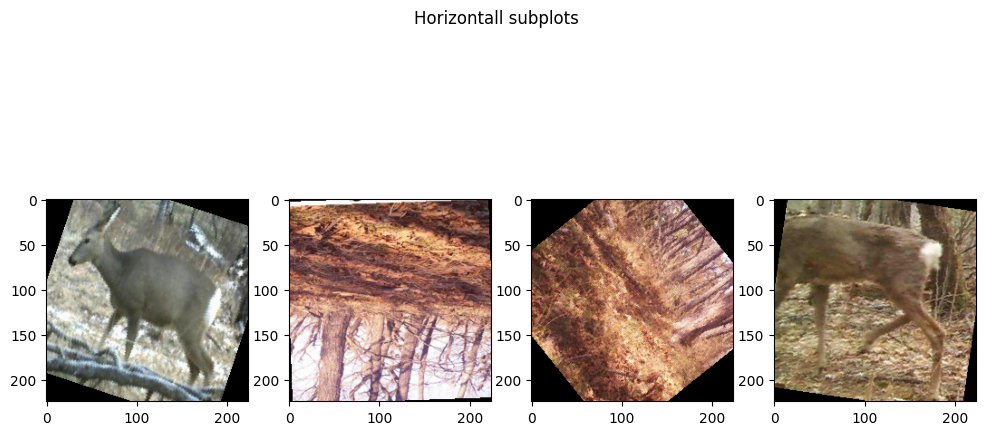

In [119]:
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=6)
fig, ax = plt.subplots(1, 4,figsize=(12,6))
fig.suptitle('Horizontall subplots')

for i in range(4):
    rand = np.random.randint(0, 200)
    item = val_dataset[rand]
    print(f"Label: {item['labels'].item()}", f"Pred: {sm_y_pred[rand]}")
    ax[i].imshow(ToPILImage()(item['pixels']))
np.set_printoptions(suppress=False, precision=6)

Prediction: tensor([[-1.0789,  4.5389, -2.5432]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([[3.6163e-03, 9.9555e-01, 8.3623e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_30/2770968169.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print("Prediction:", logits, F.softmax(logits))


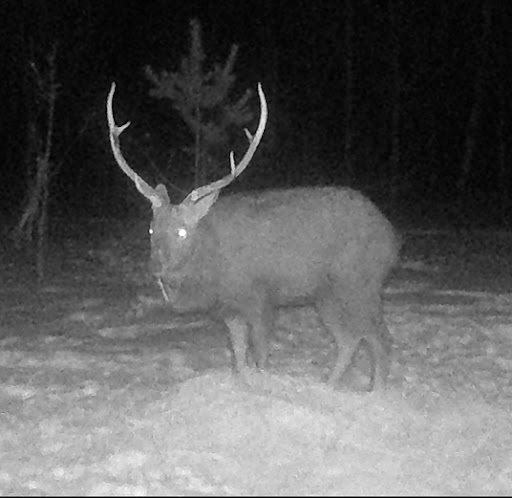

In [28]:
url = 'https://lh3.googleusercontent.com/proxy/bdVD7V23fv0oD7dAaUv9_OkMviPGO4NsUyXo_tKpkAcF7L7KjWmkwAZFiYp9VhXL5KeF-xWz2RoohsZD-1Eiih1DDdW9brXNmWLfrE1UKek8mEJ2nV-oFPU1zUD7PF5f0vxZdl7x32iYj6POQhUQXOVzofmg29ReyFFk2dFwF0zXJHsud89PkUIl7Z5H2Ln8xDzhWsNW10lKA_KeBUtv4vFpzR4dVN92tZ6oleH1HEF1tTw'
image = Image.open(requests.get(url, stream=True).raw)


inputs = processor(images=image, return_tensors="pt")
inputs["pixel_values"] = inputs["pixel_values"].cuda()
outputs = model(**inputs)
logits = outputs.logits

print("Prediction:", logits, F.softmax(logits))
image

/tmp/ipykernel_30/1017457019.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print("Prediction:", logits, F.softmax(logits))


Prediction: tensor([[-1.7461,  5.9454, -3.7572]], grad_fn=<AddmmBackward0>) tensor([[    0.0005,     0.9995,     0.0001]], grad_fn=<SoftmaxBackward0>)


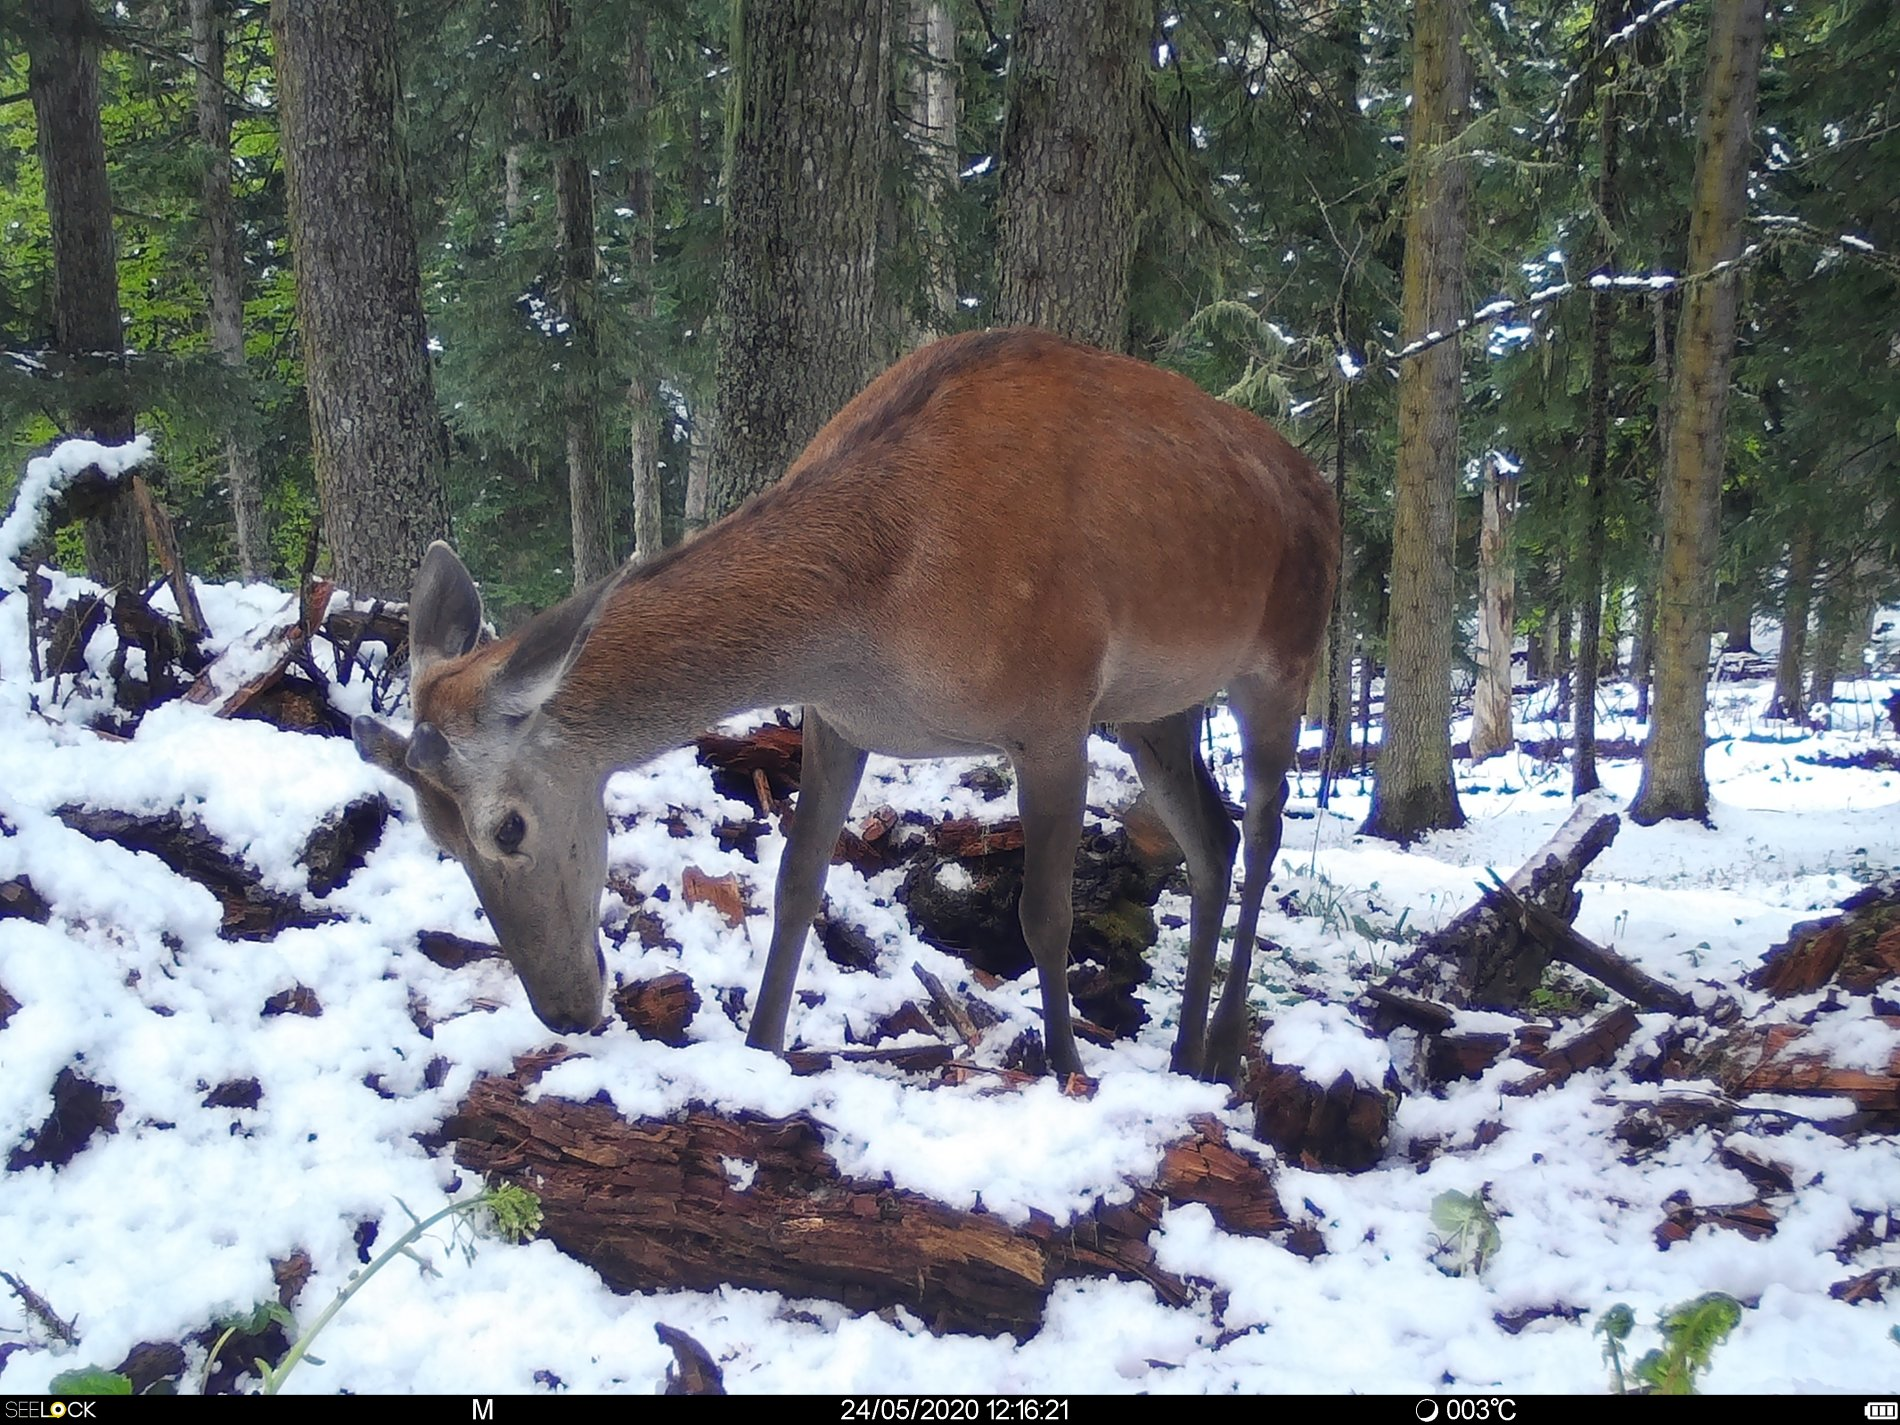

In [114]:
model = SwinForImageClassification.from_pretrained("/kaggle/input/swin/pytorch/default/1/kaggle/working/microsoft-swin-base-patch4-window7-224-3-cls-aug")
processor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224")
url = 'https://www.kavkazzapoved.ru/sites/default/files/inline-images/imag0069.jpg'
image = Image.open(requests.get(url, stream=True).raw)


inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
torch.set_printoptions(sci_mode=False)
print("Prediction:", logits, F.softmax(logits))
torch.set_printoptions(sci_mode=True)
image

In [ ]:
url = 'https://gtrk-kaluga.ru/public/upload/news/41851/gallery/.jpg'
image = Image.open(requests.get(url, stream=True).raw)


inputs = processor(images=image, return_tensors="pt")
outputs = model2(**inputs)
logits = outputs.logits
torch.set_printoptions(sci_mode=False)
print("Prediction:", logits, F.softmax(logits))
torch.set_printoptions(sci_mode=False)
image